In [17]:
%matplotlib inline
import numpy as np
from scipy import signal, io
import matplotlib.pyplot as plt

import IPython

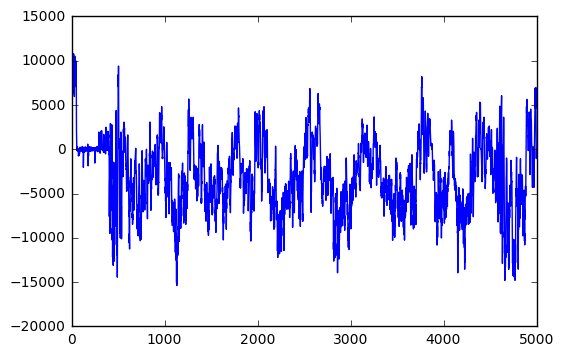

In [22]:
raw_audio = np.fromfile("comercial.raw", np.int16)

plt.plot(raw_audio[:5000])
IPython.display.Audio(raw_audio, rate=32e3)

In [8]:
io.wavfile.write("comercial.wav", rate=32000, data=raw_audio)

In [23]:
def load_iq(filename):
    x = np.fromfile(filename, np.uint8) + np.int8(-127) #adding a signed int8 to an unsigned one results in an int16 array
    return x.astype(np.int8).reshape((x.size//2, 2))	#we cast it back to an int8 array and reshape

In [24]:
def load_iq_complex(filename):
    x = np.fromfile(filename, np.uint8) - np.float32(127.5) #by subtracting a float32 the resulting array will also be float32
    return 8e-3*x.view(np.complex64)                        #viewing it as a complex64 array then yields the correct result

In [ ]:
from rtlsdr import RtlSdr
from contextlib import closing

#we use a context manager that automatically calls .close() on sdr
#whether the code block finishes successfully or an error occurs
with closing(RtlSdr()) as sdr:  
    sdr.sample_rate =2400000
    sdr.center_freq = 97.4e6
    sdr.gain = 20
    #sdr.freq_correction = 
    #sdr.bandwidth = 200000
    x = sdr.read_samples(10*sdr.sample_rate)

In [25]:
def demod_fm(x, rate_in=1020000, rate_out=30000):
    n = rate_in//rate_out
    return signal.decimate(np.diff(np.unwrap(np.arctan2(x[:,1], x[:,0]))), n, ftype='fir')
    
def demod_fm_quad(x, rate_in=1020000, rate_out=30000):
    dx = x[2:] - x[:-2]
    #num = x[1:-1,::-1]*dx
    dphase = x[1:-1,0]*dx[:,1] - x[1:-1,1]*dx[:,0]#(num[:,1]-num[:,0])
    
    n = rate_in//rate_out
    return signal.decimate(dphase, n, ftype='fir')/(2*np.mean(x**2))
    
def demod_fm_complex(x, rate_in=2400000, rate_out=32000):
    if rate_in > 200000:
        n1 = rate_in//200000
        rate_in = rate_in//n1
        x = signal.decimate(x, n1) #decimate to 200 kHz bandwidth
        
    n = rate_in//rate_out
    return signal.decimate(np.diff(np.unwrap(np.angle(x))), n, ftype='fir')
    
def demod_fm_quad_complex(x, rate_in=2400000, rate_out=32000):
    if rate_in > 200000:
        n1 = rate_in//200000
        rate_in = rate_in//n1
        x = signal.decimate(x, n1) #decimate to 200 kHz bandwidth
        
    dx = x[2:] - x[:-2]
    #num = x[1:-1,::-1]*dx
    dphase = x[1:-1,0]*dx[:,1] - x[1:-1,1]*dx[:,0]#(num[:,1]-num[:,0])
    
    n = rate_in//rate_out
    return signal.decimate(dphase, n, ftype='fir')/(2*np.mean(x**2))
#%%

In [26]:
iq_samples = load_iq_complex('comercial_s2m4_g20.dat')

In [35]:
audio = demod_fm_complex(iq_samples, rate_in=2400000, rate_out=32000)
IPython.display.Audio(audio, rate=32e3)

/home/ajoo/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)
/home/ajoo/anaconda3/lib/python3.5/site-packages/scipy/signal/filter_design.py:1092: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [32]:
2400/200

12.0